In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE


In [2]:
# ==============================================================
# 📁 0️⃣ Create folder to save all plots
# ==============================================================
output_dir = "adaptivity_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"✅ All plots will be saved in: {os.path.abspath(output_dir)}\n")


✅ All plots will be saved in: c:\Users\HP\Downloads\ML final\adaptivity_plots



In [3]:
# ==============================================================
# 1️⃣ Load the dataset
# ==============================================================
df = pd.read_csv("students_adaptability_level_online_education.csv")

print("=== Dataset Overview ===")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")
df.head()


=== Dataset Overview ===
Rows: 1205, Columns: 14



,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


### Preprocessing

In [4]:
# ==============================================================
# 2️⃣ Check for missing values
# ==============================================================
print("=== Missing Values Check ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "✅ No missing values found.\n")

=== Missing Values Check ===
✅ No missing values found.



In [5]:
# ==============================================================
# 3️⃣ Check for duplicates (do NOT remove them)
# ==============================================================
duplicates_count = df.duplicated().sum()
print(f"=== Duplicate Rows Check ===\nTotal Duplicates Found: {duplicates_count}")
if duplicates_count > 0:
    print("⚠️ Duplicates exist but will NOT be removed (kept for representation).")
print()

=== Duplicate Rows Check ===
Total Duplicates Found: 949
⚠️ Duplicates exist but will NOT be removed (kept for representation).



In [6]:
# ==============================================================
# 4️⃣ Outlier Detection (numeric columns)
# ==============================================================
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    print("=== Outlier Detection (IQR method) ===")
    for col in numeric_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        print(f"{col}: {len(outliers)} outliers")
else:
    print("✅ No numeric columns available for outlier detection.")
print()


✅ No numeric columns available for outlier detection.



In [7]:
# ==============================================================
# 5️⃣ Hybrid Encoding: Ordinal + Label Encoding
# ==============================================================
df_encoded = df.copy()

ordinal_mappings = {
    'Age': ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30'],
    'Education Level': ['School', 'College', 'University'],
    'Load-shedding': ['Low', 'High'],
    'Financial Condition': ['Poor', 'Mid', 'Rich'],
    'Network Type': ['2G', '3G', '4G'],
    'Class Duration': ['0', '1-3', '3-6'],
    'Adaptivity Level': ['Low', 'Moderate', 'High']  # Target
}

ordinal_features = list(ordinal_mappings.keys())
nominal_features = [col for col in df.columns if col not in ordinal_features]

# Apply Ordinal Encoding
ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_features])
df_encoded[ordinal_features] = ordinal_encoder.fit_transform(df_encoded[ordinal_features])

# Apply Label Encoding for Nominal Features
label_encoders = {}
encoding_mappings = {}
for col in nominal_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    encoding_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Record ordinal mappings
for col in ordinal_mappings:
    encoding_mappings[col] = {cat: i for i, cat in enumerate(ordinal_mappings[col])}

print("✅ Hybrid Encoding Complete.\n")

# 1️⃣ Show the encoding mappings for all columns
print("🔹 Encoding Mappings:\n")
for col, mapping in encoding_mappings.items():
    print(f"{col}: {mapping}")
    print("-" * 50)



✅ Hybrid Encoding Complete.

🔹 Encoding Mappings:

Gender: {'Boy': np.int64(0), 'Girl': np.int64(1)}
--------------------------------------------------
Institution Type: {'Government': np.int64(0), 'Non Government': np.int64(1)}
--------------------------------------------------
IT Student: {'No': np.int64(0), 'Yes': np.int64(1)}
--------------------------------------------------
Location: {'No': np.int64(0), 'Yes': np.int64(1)}
--------------------------------------------------
Internet Type: {'Mobile Data': np.int64(0), 'Wifi': np.int64(1)}
--------------------------------------------------
Self Lms: {'No': np.int64(0), 'Yes': np.int64(1)}
--------------------------------------------------
Device: {'Computer': np.int64(0), 'Mobile': np.int64(1), 'Tab': np.int64(2)}
--------------------------------------------------
Age: {'1-5': 0, '6-10': 1, '11-15': 2, '16-20': 3, '21-25': 4, '26-30': 5}
--------------------------------------------------
Education Level: {'School': 0, 'College': 1, 

In [8]:
# ==============================================================
# 6️⃣ Split into Training and Testing Sets
# ==============================================================
X = df_encoded.drop(columns=['Adaptivity Level'])
y = df_encoded['Adaptivity Level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n✅ Data split into training and test sets.")
print(f"Training set: {X_train.shape[0]} rows")
print(f"Testing set: {X_test.shape[0]} rows\n")



✅ Data split into training and test sets.
Training set: 964 rows
Testing set: 241 rows



In [9]:
# ==============================================================
# Helper: decode adaptivity numeric -> label for readable plots
# ==============================================================
adaptivity_labels = ordinal_mappings['Adaptivity Level']  # ['Low','Moderate','High']
# y_train currently encoded as 0/1/2 matching ordinal mapping order
y_train_readable = y_train.map({i: label for i, label in enumerate(adaptivity_labels)})


=== Class Distribution After SMOTE ===
Adaptivity Level
Moderate    500
Low         500
High        500
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\1052166597.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train_res_readable, palette="cool")


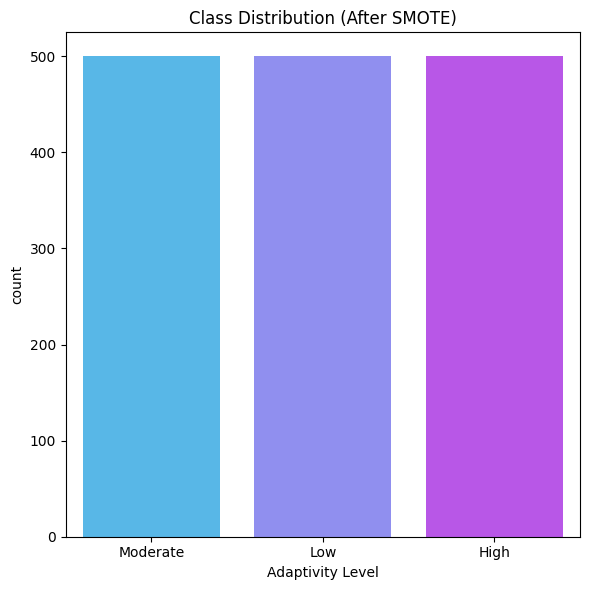

✅ Class distribution after SMOTE saved as 'adaptivity_plots\class_distribution_after_smote.png'



In [ ]:
# ==============================================================
# 8️⃣ Apply SMOTE  (Training Data Only) — show & save
# ==============================================================
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# decode resampled target for plotting (map numbers to labels)
y_train_res_readable = pd.Series(y_train_resampled).map({i: label for i, label in enumerate(adaptivity_labels)})

print("=== Class Distribution After SMOTE ===")
print(y_train_res_readable.value_counts())

plt.figure(figsize=(2, 2))
ax = sns.countplot(x=y_train_res_readable, palette="cool")
plt.title("Class Distribution (After SMOTE)")
plt.xlabel("Adaptivity Level")
plt.tight_layout()
fname = os.path.join(output_dir, "class_distribution_after_smote.png")
plt.savefig(fname, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

print(f"✅ Class distribution after SMOTE saved as '{fname}'\n")



In [17]:
# ==============================================================
# 9️⃣ Ready for Model Fitting
# ==============================================================
print(f"Training features: {X_train_resampled.shape}")
print(f"Testing features:  {X_test.shape}")
print("✅ Data ready for modeling after SMOTE.")

Training features: (1500, 13)
Testing features:  (241, 13)
✅ Data ready for modeling after SMOTE.


### Advanced Analysis

##### RANDOM FOREST CLASSIFIER

=== RANDOM FOREST PERFORMANCE ===

Training Accuracy: 0.9413
Test Accuracy:     0.9004

Classification Report (Test Data):
              precision    recall  f1-score   support

         Low       0.93      0.94      0.93        96
    Moderate       0.94      0.87      0.90       125
        High       0.64      0.90      0.75        20

    accuracy                           0.90       241
   macro avg       0.84      0.90      0.86       241
weighted avg       0.91      0.90      0.90       241



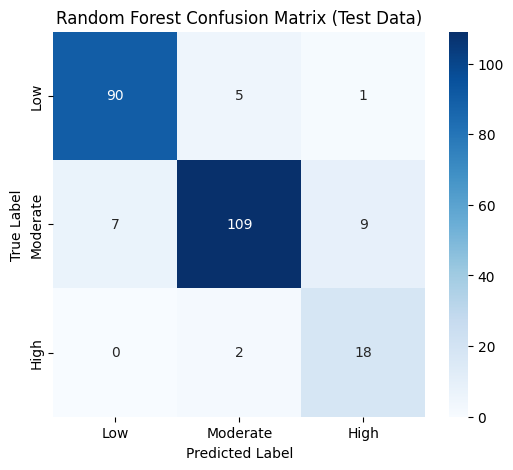

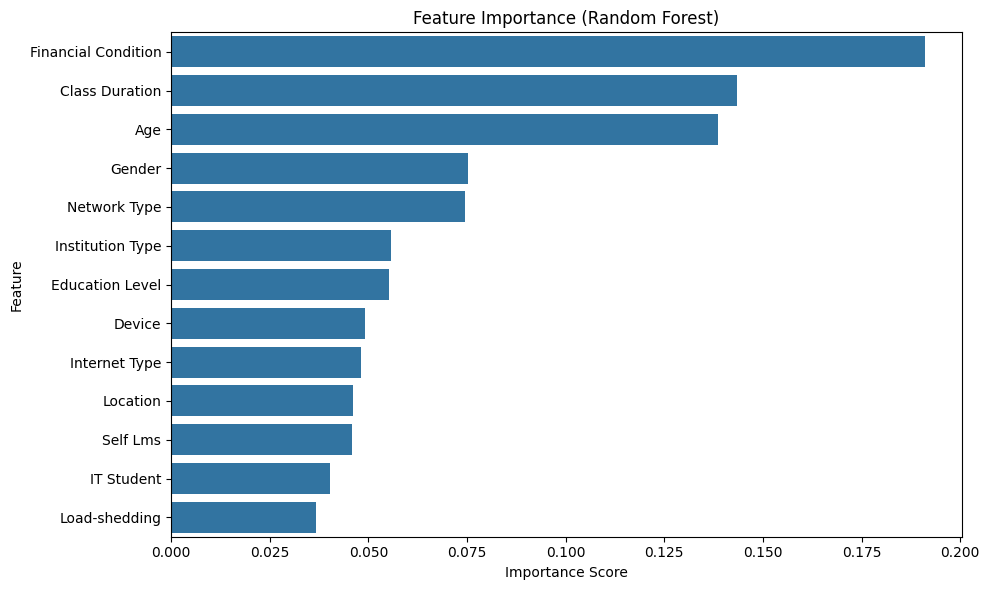


Top 10 Important Features:
Financial Condition    0.190946
Class Duration         0.143368
Age                    0.138489
Gender                 0.075133
Network Type           0.074500
Institution Type       0.055676
Education Level        0.055329
Device                 0.049244
Internet Type          0.048203
Location               0.046145
dtype: float64


In [18]:
# ==============================================================
#  RANDOM FOREST CLASSIFIER
# ==============================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================
# 1️⃣ Train Random Forest on SMOTE-balanced training data
# ==============================================================

rf_model = RandomForestClassifier(
    n_estimators=200,           # number of trees
    max_depth=None,             # allow full growth
    min_samples_split=2,        # default split criterion
    min_samples_leaf=1,         # default leaf size
    random_state=42,
    n_jobs=-1                   # use all CPU cores
)

rf_model.fit(X_train_resampled, y_train_resampled)

# ==============================================================
# 2️⃣ Predictions
# ==============================================================

y_train_pred = rf_model.predict(X_train_resampled)
y_test_pred = rf_model.predict(X_test)

# ==============================================================
# 3️⃣ Evaluate performance
# ==============================================================

print("=== RANDOM FOREST PERFORMANCE ===\n")

# --- Train performance ---
train_acc = accuracy_score(y_train_resampled, y_train_pred)
print(f"Training Accuracy: {train_acc:.4f}")

# --- Test performance ---
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy:     {test_acc:.4f}\n")

# --- Classification report ---
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred, target_names=['Low', 'Moderate', 'High']))

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Moderate', 'High'],
            yticklabels=['Low', 'Moderate', 'High'])
plt.title("Random Forest Confusion Matrix (Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ==============================================================
# 4️⃣ Feature Importance
# ==============================================================

importances = pd.Series(rf_model.feature_importances_, index=X_train_resampled.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(importances.head(10))


🔍 Running RandomizedSearchCV (This may take several minutes)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

=== BEST PARAMETERS FOUND ===
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'criterion': 'gini', 'bootstrap': True}

=== RANDOM FOREST PERFORMANCE (TUNED) ===
Training Accuracy: 0.9413
Test Accuracy:     0.9004

=== CLASSIFICATION REPORT (TEST DATA) ===
              precision    recall  f1-score   support

         Low       0.93      0.94      0.93        96
    Moderate       0.94      0.87      0.90       125
        High       0.64      0.90      0.75        20

    accuracy                           0.90       241
   macro avg       0.84      0.90      0.86       241
weighted avg       0.91      0.90      0.90       241



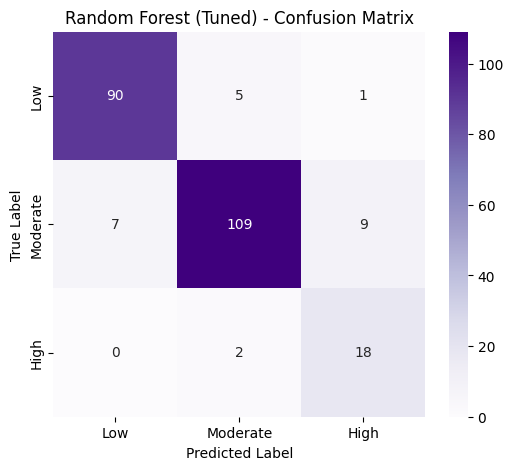

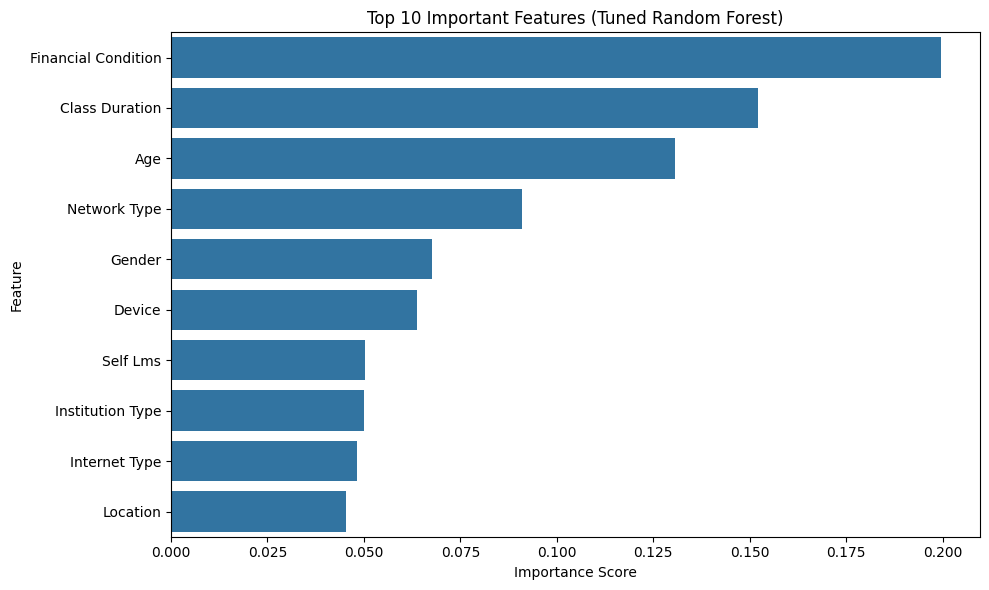

In [19]:
# ==============================================================
# ADVANCED HYPERPARAMETER TUNING – RANDOM FOREST (EXPANDED SEARCH)
# ==============================================================

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Define base model
rf_base = RandomForestClassifier(random_state=42)

# Define a broader parameter grid for better exploration
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Randomized Search setup
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=100,             # ⬆️ Increase iterations for better exploration
    cv=5,                   # 5-fold CV
    verbose=2,              # show progress
    random_state=42,
    n_jobs=-1,              # use all cores
    scoring='accuracy'
)

# Fit using SMOTE-balanced training data
print("🔍 Running RandomizedSearchCV (This may take several minutes)...")
rf_random.fit(X_train_resampled, y_train_resampled)

# Display the best parameters
print("\n=== BEST PARAMETERS FOUND ===")
print(rf_random.best_params_)

# Evaluate the best model
best_rf = rf_random.best_estimator_

y_train_pred = best_rf.predict(X_train_resampled)
y_test_pred = best_rf.predict(X_test)

print("\n=== RANDOM FOREST PERFORMANCE (TUNED) ===")
print(f"Training Accuracy: {accuracy_score(y_train_resampled, y_train_pred):.4f}")
print(f"Test Accuracy:     {accuracy_score(y_test, y_test_pred):.4f}\n")

print("=== CLASSIFICATION REPORT (TEST DATA) ===")
print(classification_report(y_test, y_test_pred, target_names=['Low', 'Moderate', 'High']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Low', 'Moderate', 'High'],
            yticklabels=['Low', 'Moderate', 'High'])
plt.title("Random Forest (Tuned) - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Feature importance from tuned model
importances = pd.Series(best_rf.feature_importances_, index=X_train_resampled.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(10), y=importances.head(10).index)
plt.title("Top 10 Important Features (Tuned Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


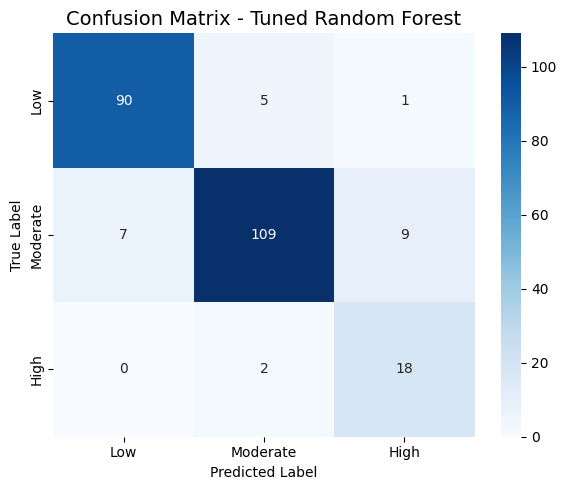

C:\Users\HP\AppData\Local\Temp\ipykernel_25204\1576956127.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


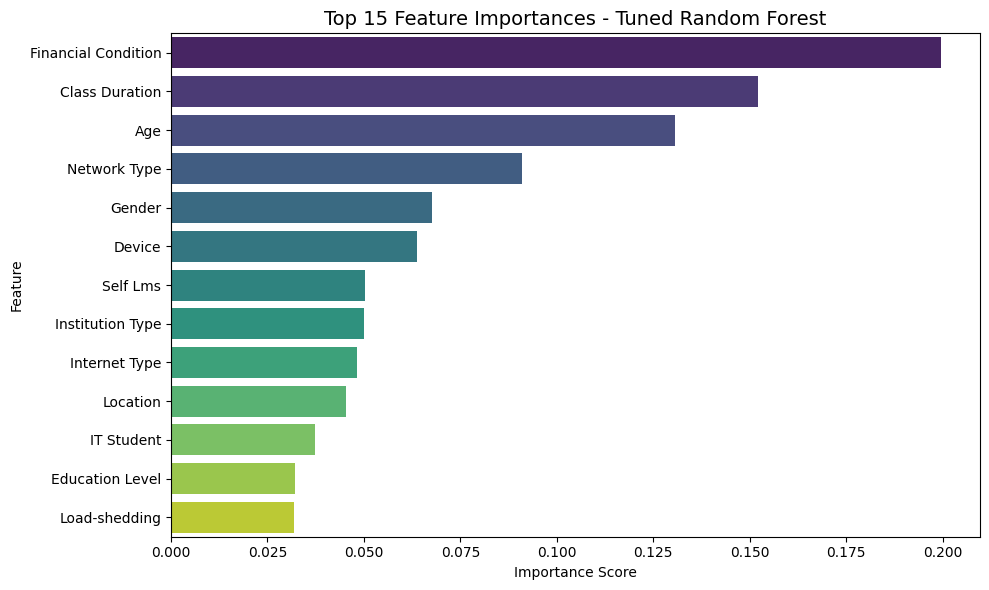

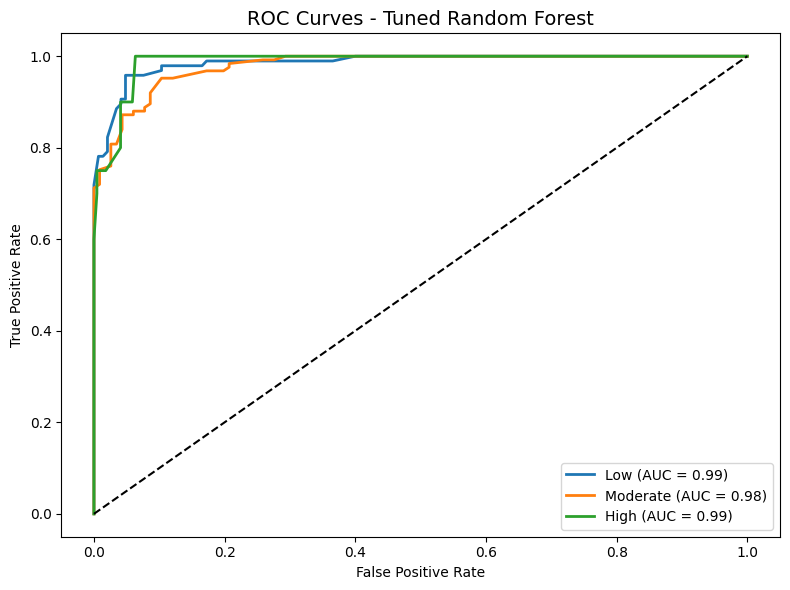

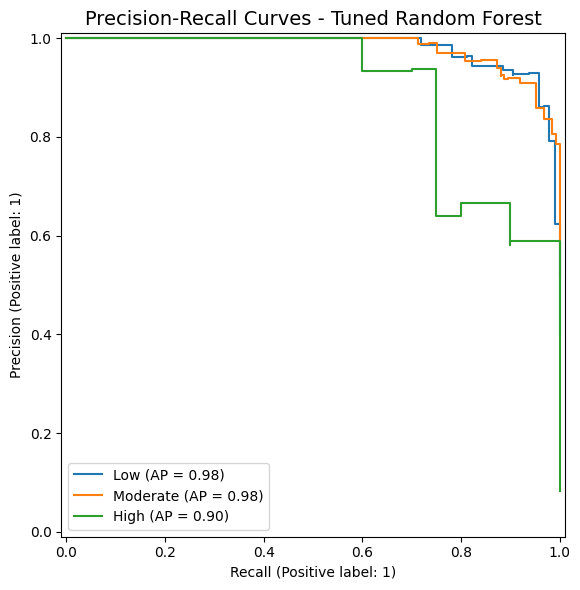

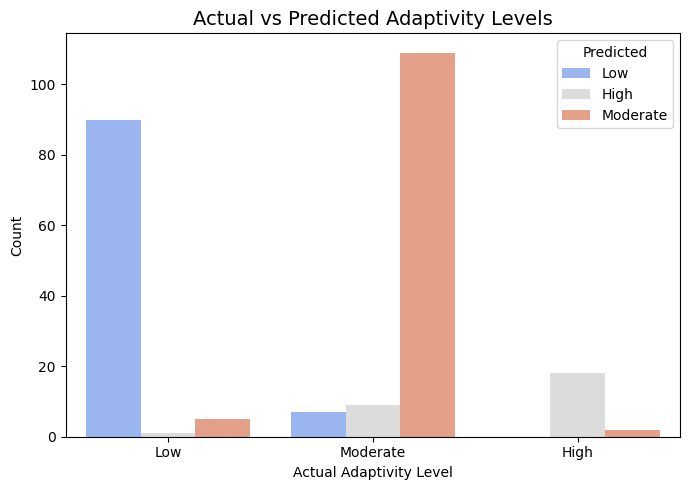


✅ All visualizations saved in 'rf_visuals/' folder.


In [20]:
# ===============================================
# 🎯 RANDOM FOREST PERFORMANCE VISUALIZATIONS
# ===============================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# Create a folder for outputs (optional)
import os
os.makedirs("rf_visuals", exist_ok=True)

# 1️⃣ Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
            annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Moderate', 'High'], 
            yticklabels=['Low', 'Moderate', 'High'])
plt.title("Confusion Matrix - Tuned Random Forest", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("rf_visuals/confusion_matrix_rf.png", dpi=300)
plt.show()


# 2️⃣ Feature Importance Plot
import numpy as np

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(
    y=X_train_resampled.columns[indices][:15],
    x=importances[indices][:15],
    palette="viridis"
)
plt.title("Top 15 Feature Importances - Tuned Random Forest", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("rf_visuals/feature_importance_rf.png", dpi=300)
plt.show()


# 3️⃣ ROC Curves (One-vs-Rest for Multi-Class)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay

# Binarize labels for multi-class
y_test_bin = label_binarize(y_test, classes=[0.0, 1.0, 2.0])
y_pred_prob = best_rf.predict_proba(X_test)  # list of arrays for multi-class in RF

plt.figure(figsize=(8, 6))
for i, label in enumerate(['Low', 'Moderate', 'High']):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves - Tuned Random Forest", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("rf_visuals/roc_curves_rf.png", dpi=300)
plt.show()


# 4️⃣ Precision-Recall Curves
plt.figure(figsize=(8, 6))
for i, label in enumerate(['Low', 'Moderate', 'High']):
    PrecisionRecallDisplay.from_predictions(
        y_test_bin[:, i],
        y_pred_prob[:, i],
        name=label,
        ax=plt.gca()
    )
plt.title("Precision-Recall Curves - Tuned Random Forest", fontsize=14)
plt.tight_layout()
plt.savefig("rf_visuals/pr_curves_rf.png", dpi=300)
plt.show()


# 5️⃣ Actual vs Predicted Comparison
comparison_df = (
    pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
    .replace({0.0: 'Low', 1.0: 'Moderate', 2.0: 'High'})
)

plt.figure(figsize=(7, 5))
sns.countplot(data=comparison_df, x='Actual', hue='Predicted', palette='coolwarm')
plt.title("Actual vs Predicted Adaptivity Levels", fontsize=14)
plt.xlabel("Actual Adaptivity Level")
plt.ylabel("Count")
plt.legend(title='Predicted')
plt.tight_layout()
plt.savefig("rf_visuals/actual_vs_pred_rf.png", dpi=300)
plt.show()

print("\n✅ All visualizations saved in 'rf_visuals/' folder.")


In [21]:
#!pip install shap

c:\Users\HP\Downloads\ML final\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


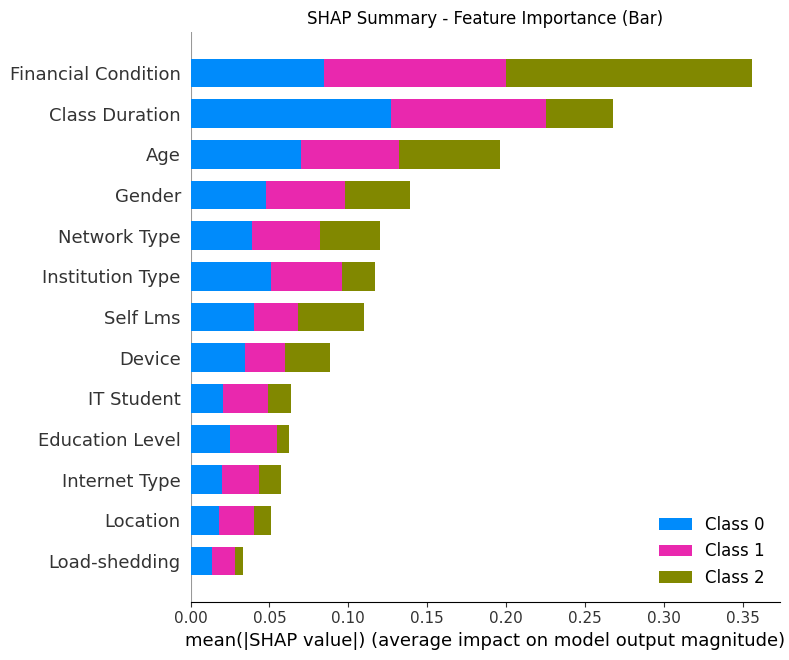

<Figure size 1000x600 with 0 Axes>

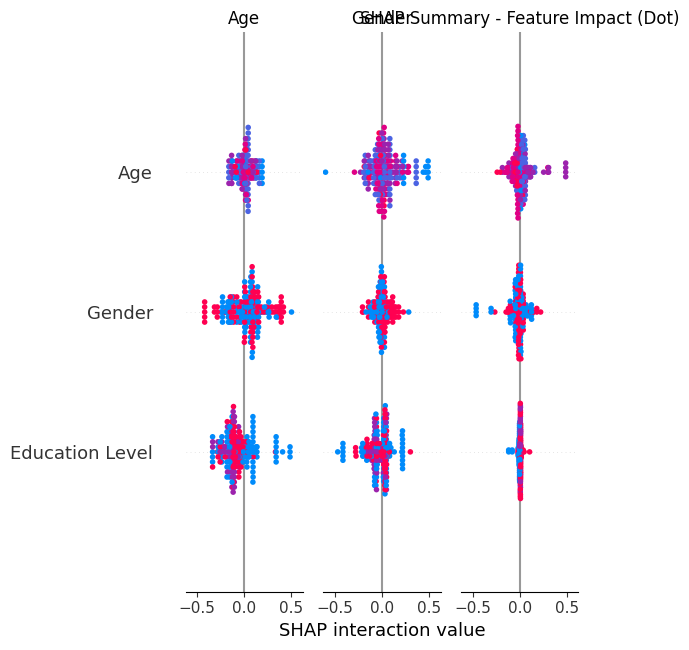

In [22]:
import shap
import os

# Create folder for SHAP visuals
os.makedirs("rf_visuals/shap", exist_ok=True)

# 1️⃣ Create SHAP explainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# 2️⃣ Summary Plot (bar) - global feature importance
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary - Feature Importance (Bar)")
plt.tight_layout()
plt.savefig("rf_visuals/shap/shap_summary_bar.png", dpi=300)
plt.show()

# 3️⃣ Summary Plot (dot) - feature impact
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Summary - Feature Impact (Dot)")
plt.tight_layout()
plt.savefig("rf_visuals/shap/shap_summary_dot.png", dpi=300)
plt.show()



##### XGBoost, AdaBoost, CatBoost, LightGBM

In [23]:
#!pip install xgboost catboost lightgbm

In [24]:
# ML Models
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

# Metrics & plotting
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create folder for visuals
os.makedirs("boosting_visuals", exist_ok=True)


In [25]:
def train_eval_model(model, model_name):
    # Train
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train_resampled, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"\n=== {model_name} ===")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {test_acc:.4f}")
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, y_test_pred, target_names=['Low','Moderate','High']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low','Moderate','High'],
                yticklabels=['Low','Moderate','High'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"boosting_visuals/{model_name}_confusion_matrix.png", dpi=300)
    plt.show()
    
    # Feature Importance (if available)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = importances.argsort()[::-1]
        plt.figure(figsize=(5,3))
        sns.barplot(y=X_train_resampled.columns[indices][:15],
                    x=importances[indices][:15], palette="viridis")
        plt.title(f"{model_name} Top 15 Feature Importances")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig(f"boosting_visuals/{model_name}_feature_importance.png", dpi=300)
        plt.show()
    
    return model


c:\Users\HP\Downloads\ML final\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:59:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Training Accuracy: 0.9413
Test Accuracy:     0.9004

Classification Report (Test Data):
              precision    recall  f1-score   support

         Low       0.93      0.94      0.93        96
    Moderate       0.94      0.87      0.90       125
        High       0.64      0.90      0.75        20

    accuracy                           0.90       241
   macro avg       0.84      0.90      0.86       241
weighted avg       0.91      0.90      0.90       241



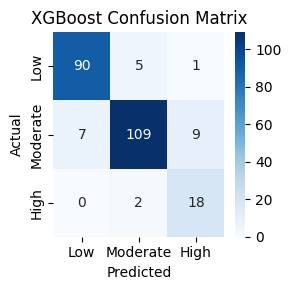

C:\Users\HP\AppData\Local\Temp\ipykernel_25204\1327576347.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=X_train_resampled.columns[indices][:15],


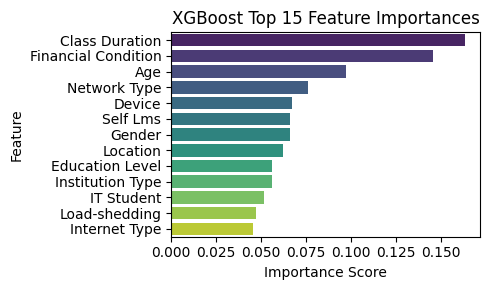

In [26]:
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model = train_eval_model(xgb_model, "XGBoost")



=== AdaBoost ===
Training Accuracy: 0.6440
Test Accuracy:     0.6390

Classification Report (Test Data):
              precision    recall  f1-score   support

         Low       0.78      0.44      0.56        96
    Moderate       0.65      0.80      0.72       125
        High       0.35      0.60      0.44        20

    accuracy                           0.64       241
   macro avg       0.59      0.61      0.57       241
weighted avg       0.68      0.64      0.63       241



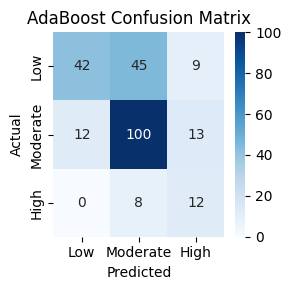

C:\Users\HP\AppData\Local\Temp\ipykernel_25204\1327576347.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=X_train_resampled.columns[indices][:15],


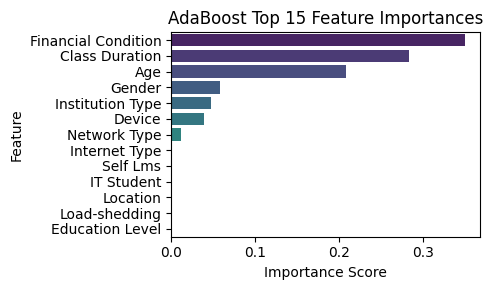

In [27]:
ada_model = AdaBoostClassifier(
    n_estimators=400,
    learning_rate=0.1,
    random_state=42
)
ada_model = train_eval_model(ada_model, "AdaBoost")



=== CatBoost ===
Training Accuracy: 0.9407
Test Accuracy:     0.9004

Classification Report (Test Data):
              precision    recall  f1-score   support

         Low       0.93      0.94      0.93        96
    Moderate       0.94      0.87      0.90       125
        High       0.64      0.90      0.75        20

    accuracy                           0.90       241
   macro avg       0.84      0.90      0.86       241
weighted avg       0.91      0.90      0.90       241



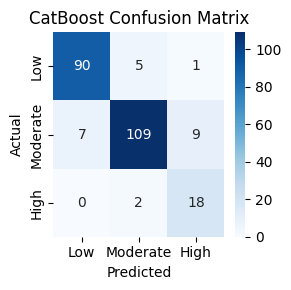

C:\Users\HP\AppData\Local\Temp\ipykernel_25204\1327576347.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=X_train_resampled.columns[indices][:15],


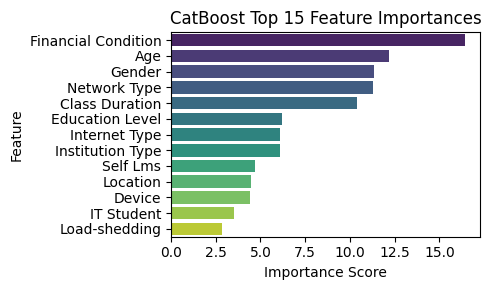

In [28]:
cat_model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    verbose=0,
    random_state=42
)
cat_model = train_eval_model(cat_model, "CatBoost")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

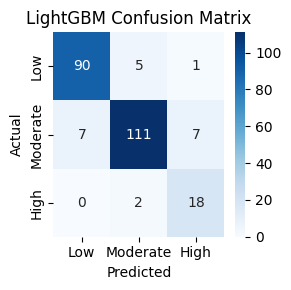

C:\Users\HP\AppData\Local\Temp\ipykernel_25204\1327576347.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=X_train_resampled.columns[indices][:15],


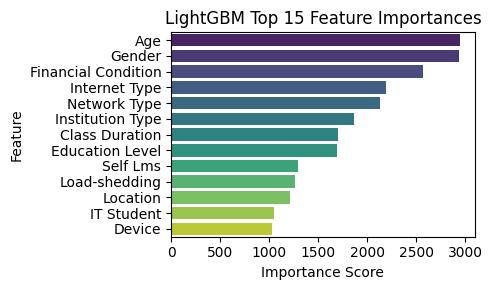

In [29]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
lgb_model = train_eval_model(lgb_model, "LightGBM")


In [30]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Use accuracy as scoring
scorer = make_scorer(accuracy_score)


In [31]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [3, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=30,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train_resampled, y_train_resampled)

best_xgb = xgb_search.best_estimator_
print("=== Best XGBoost Params ===")
print(xgb_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\HP\Downloads\ML final\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:00:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Best XGBoost Params ===
{'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [32]:
lgb_model = lgb.LGBMClassifier(random_state=42)

lgb_param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [3, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 30, 40, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgb_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=30,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lgb_search.fit(X_train_resampled, y_train_resampled)
best_lgb = lgb_search.best_estimator_
print("=== Best LightGBM Params ===")
print(lgb_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [33]:
ada_model = AdaBoostClassifier(random_state=42)

ada_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

ada_search = RandomizedSearchCV(
    estimator=ada_model,
    param_distributions=ada_param_grid,
    n_iter=20,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

ada_search.fit(X_train_resampled, y_train_resampled)
best_ada = ada_search.best_estimator_
print("=== Best AdaBoost Params ===")
print(ada_search.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\HP\Downloads\ML final\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


=== Best AdaBoost Params ===
{'n_estimators': 400, 'learning_rate': 0.1}


In [34]:
cat_model = CatBoostClassifier(loss_function='MultiClass', verbose=0, random_state=42)

cat_param_grid = {
    'iterations': [200, 300, 400, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat_search = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)

cat_search.fit(X_train_resampled, y_train_resampled)
best_cat = cat_search.best_estimator_
print("=== Best CatBoost Params ===")
print(cat_search.best_params_)


Fitting 5 folds for each of 256 candidates, totalling 1280 fits
=== Best CatBoost Params ===
{'depth': 6, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.2}


In [35]:
def eval_boosting_model(model, model_name):
    import shap
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc, PrecisionRecallDisplay
    
    # Predict
    y_test_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    
    # Accuracy & classification report
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred, target_names=['Low','Moderate','High']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low','Moderate','High'],
                yticklabels=['Low','Moderate','High'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"boosting_visuals/{model_name}_confusion_matrix.png", dpi=300)
    plt.show()
    
    # ROC Curve
    y_test_bin = label_binarize(y_test, classes=[0.0,1.0,2.0])
    plt.figure(figsize=(8,6))
    for i, label in enumerate(['Low','Moderate','High']):
        fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_pred_prob[:,i])
        plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"{model_name} ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"boosting_visuals/{model_name}_roc.png", dpi=300)
    plt.show()
    
    # Precision-Recall Curve
    plt.figure(figsize=(8,6))
    for i, label in enumerate(['Low','Moderate','High']):
        PrecisionRecallDisplay.from_predictions(
            y_test_bin[:,i],
            y_pred_prob[:,i],
            name=label,
            ax=plt.gca()
        )
    plt.title(f"{model_name} Precision-Recall Curves")
    plt.tight_layout()
    plt.savefig(f"boosting_visuals/{model_name}_pr.png", dpi=300)
    plt.show()
    
    # === SHAP Analysis (Only for tree-based models that support it) ===
    if hasattr(model, 'feature_importances_') and model_name not in ['AdaBoost']:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        plt.figure(figsize=(10,6))
        shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
        plt.tight_layout()
        plt.savefig(f"rf_visuals/shap/shap_summary_{model_name}.png", dpi=300)
        plt.close()
    else:
        print(f"SHAP not supported for {model_name}, skipping visualization.")



=== XGBoost ===
Accuracy: 0.9004149377593361
              precision    recall  f1-score   support

         Low       0.93      0.94      0.93        96
    Moderate       0.94      0.87      0.90       125
        High       0.64      0.90      0.75        20

    accuracy                           0.90       241
   macro avg       0.84      0.90      0.86       241
weighted avg       0.91      0.90      0.90       241



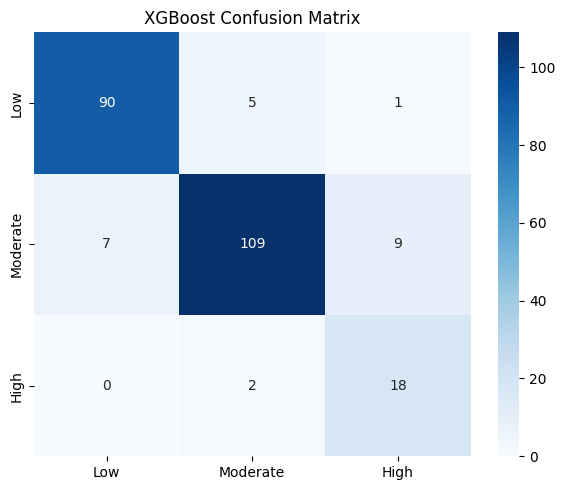

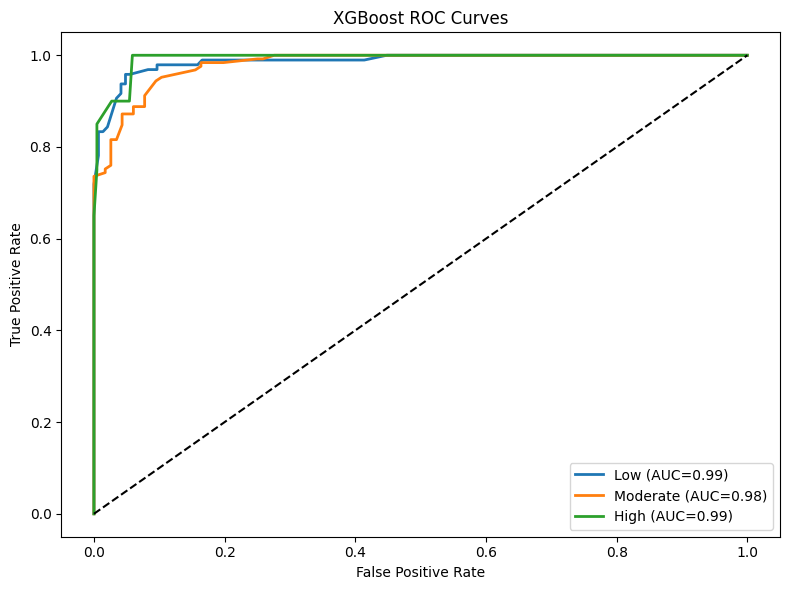

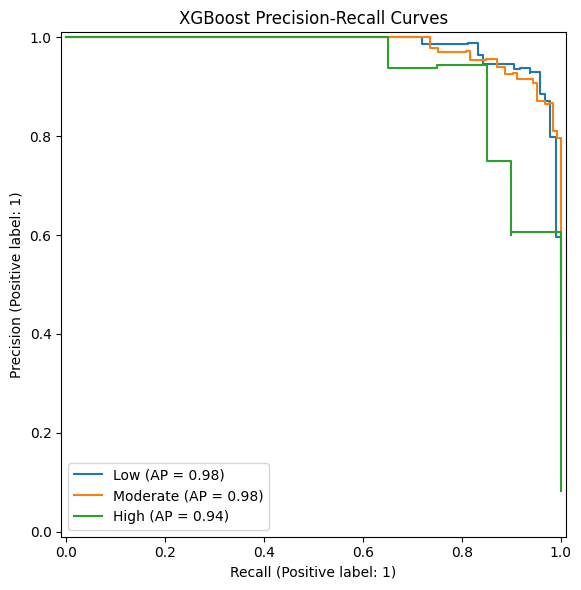


=== LightGBM ===
Accuracy: 0.9087136929460581
              precision    recall  f1-score   support

         Low       0.93      0.94      0.93        96
    Moderate       0.94      0.89      0.91       125
        High       0.69      0.90      0.78        20

    accuracy                           0.91       241
   macro avg       0.85      0.91      0.88       241
weighted avg       0.91      0.91      0.91       241



<Figure size 1000x600 with 0 Axes>

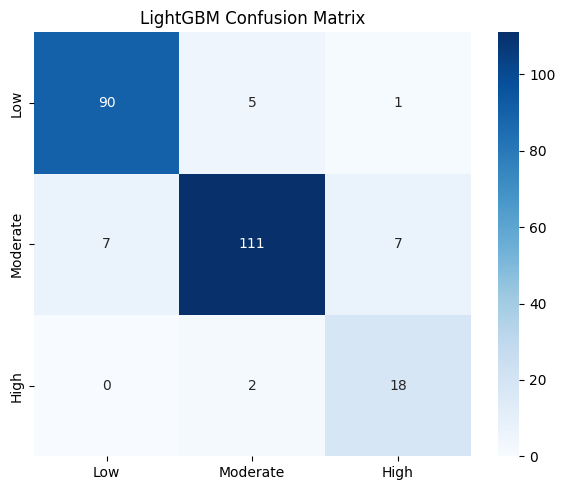

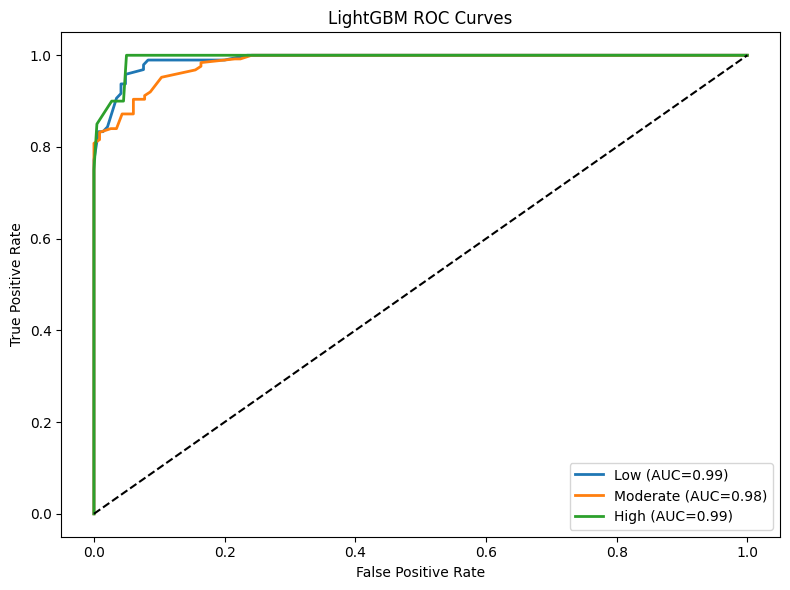

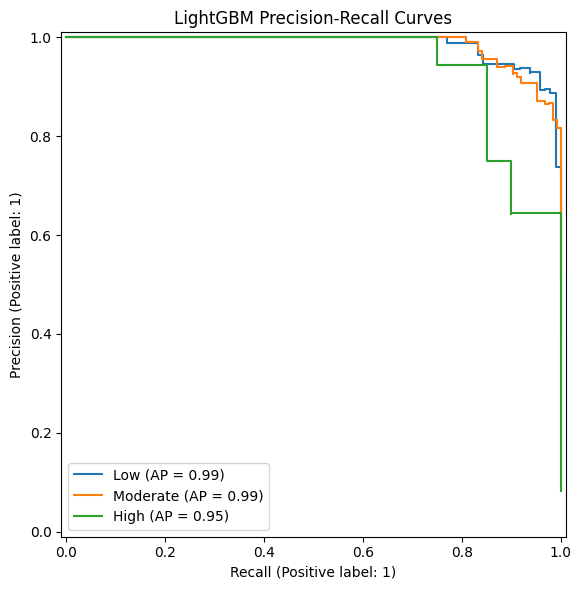


=== AdaBoost ===
Accuracy: 0.6390041493775933
              precision    recall  f1-score   support

         Low       0.78      0.44      0.56        96
    Moderate       0.65      0.80      0.72       125
        High       0.35      0.60      0.44        20

    accuracy                           0.64       241
   macro avg       0.59      0.61      0.57       241
weighted avg       0.68      0.64      0.63       241



<Figure size 1000x600 with 0 Axes>

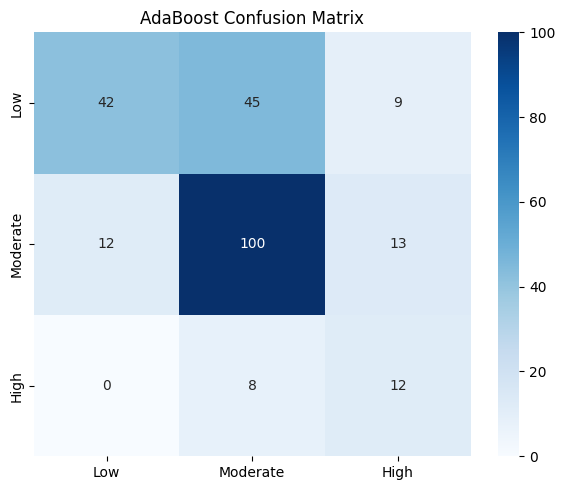

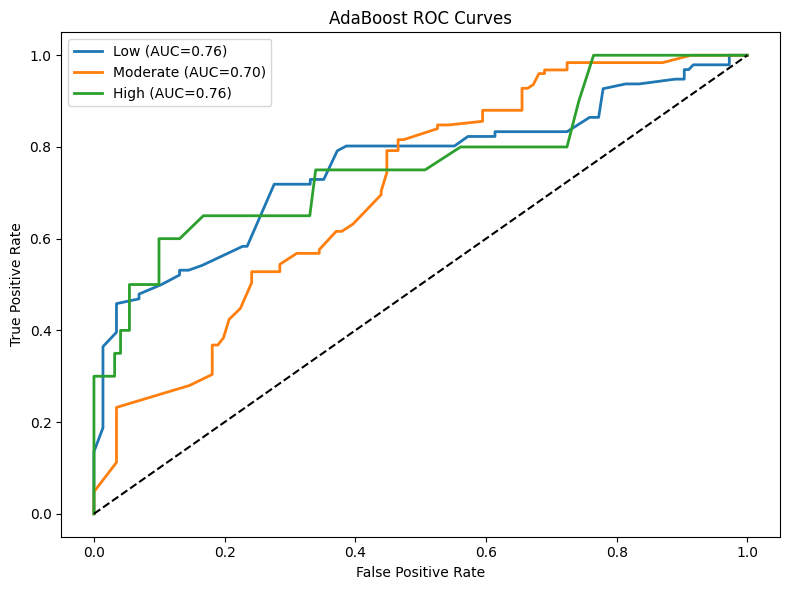

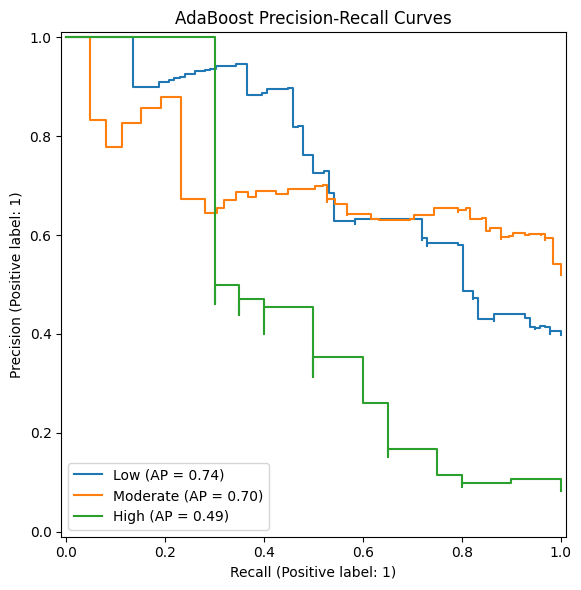

SHAP not supported for AdaBoost, skipping visualization.

=== CatBoost ===
Accuracy: 0.9087136929460581
              precision    recall  f1-score   support

         Low       0.93      0.94      0.93        96
    Moderate       0.94      0.89      0.91       125
        High       0.69      0.90      0.78        20

    accuracy                           0.91       241
   macro avg       0.85      0.91      0.88       241
weighted avg       0.91      0.91      0.91       241



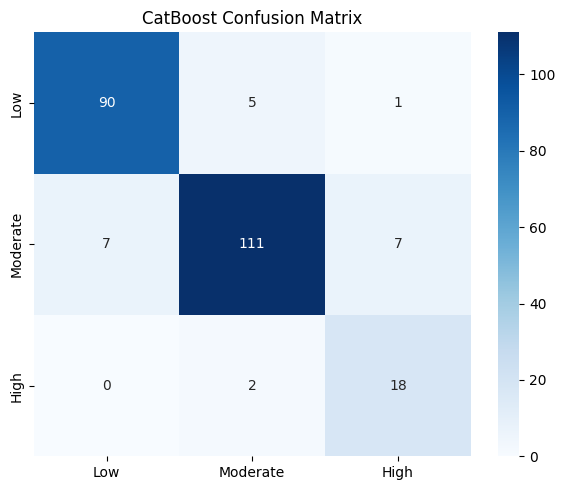

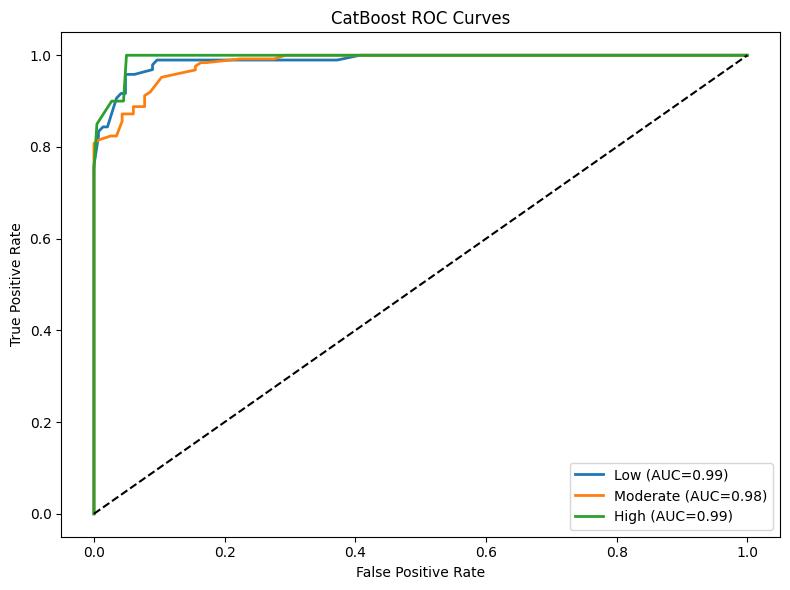

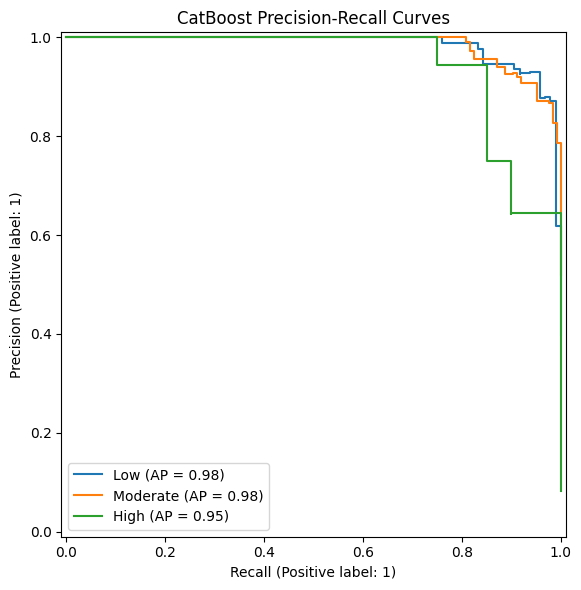

<Figure size 1000x600 with 0 Axes>

In [36]:
eval_boosting_model(best_xgb, "XGBoost")
eval_boosting_model(best_lgb, "LightGBM")
eval_boosting_model(best_ada, "AdaBoost")
eval_boosting_model(best_cat, "CatBoost")


#### PDP (Inbuild)

c:\Users\HP\Downloads\ML final\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\HP\Downloads\ML final\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\HP\Downloads\ML final\.venv\Lib\site-packages\sklearn\inspe

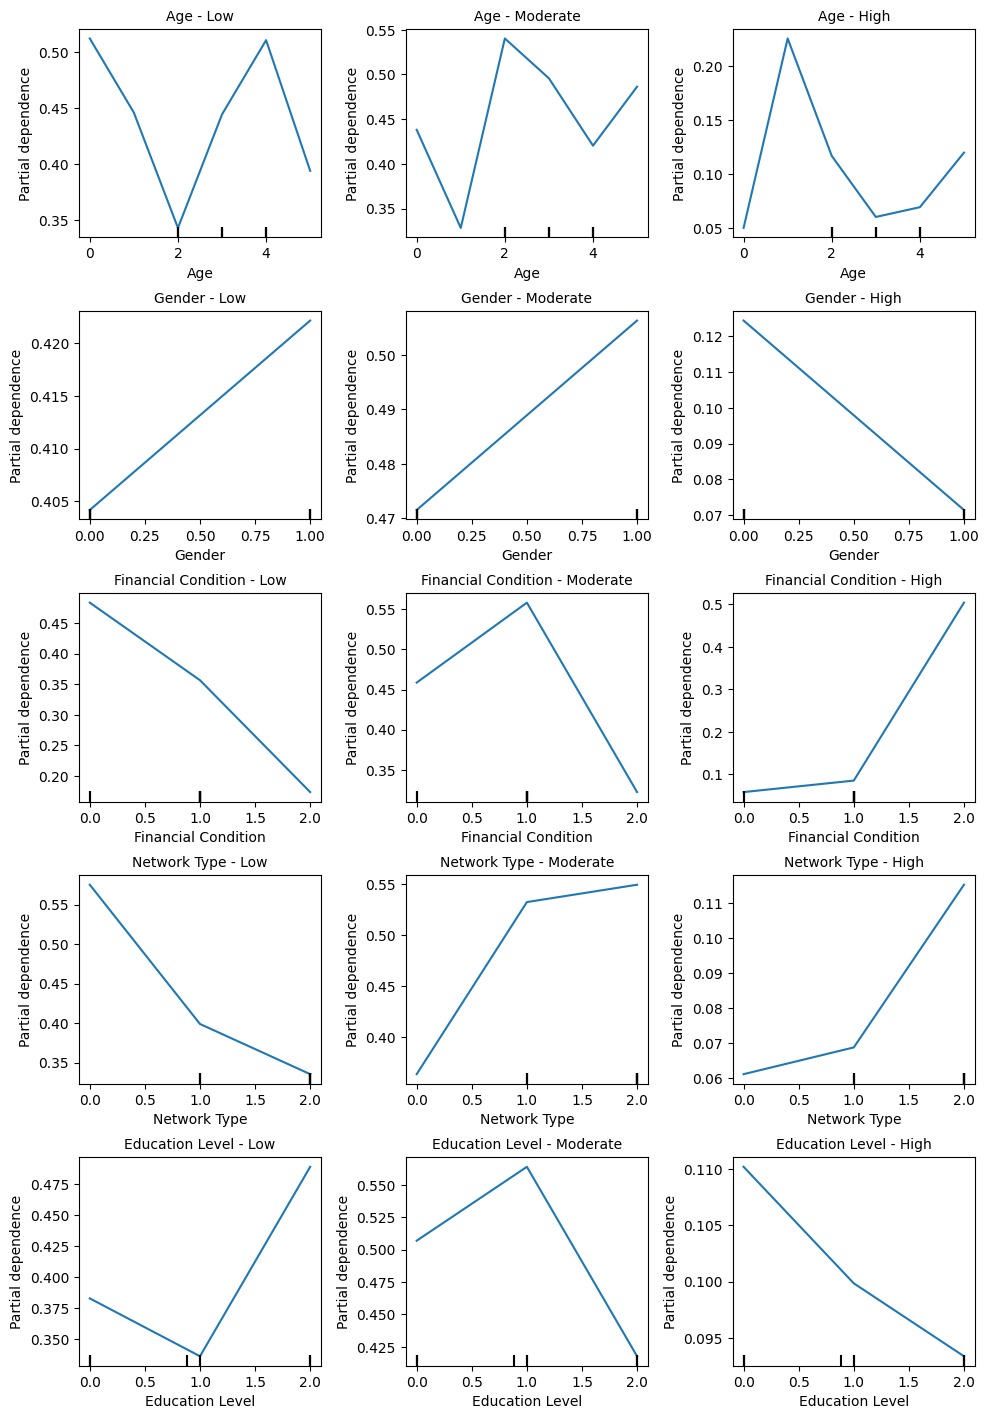

In [43]:
from sklearn.inspection import PartialDependenceDisplay
import os
import matplotlib.pyplot as plt

# Folder for PDPs
pdp_dir = "boosting_visuals/pdp_plots"
os.makedirs(pdp_dir, exist_ok=True)

top_features = ['Age', 'Gender', 'Financial Condition', 'Network Type', 'Education Level']
target_mapping = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Create a 5x3 grid for 5 features × 3 classes
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 15))
axes = axes.flatten()

plot_idx = 0
for feature in top_features:
    for class_idx, class_name in target_mapping.items():
        ax = axes[plot_idx]
        display = PartialDependenceDisplay.from_estimator(
            best_lgb,
            X=X_test,
            features=[feature],
            target=class_idx,
            kind="average",
            ax=ax
        )
        ax.set_title(f"{feature} - {class_name}", fontsize=10)
        plot_idx += 1


plt.tight_layout()
plt.subplots_adjust(top=0.93)

# Save all in one image
combined_path = os.path.join(pdp_dir, "PDP_AllFeatures_AllClasses.png")
plt.savefig(combined_path, dpi=300)
plt.show()




#### PDP (Manual)
##### All classes in same plot

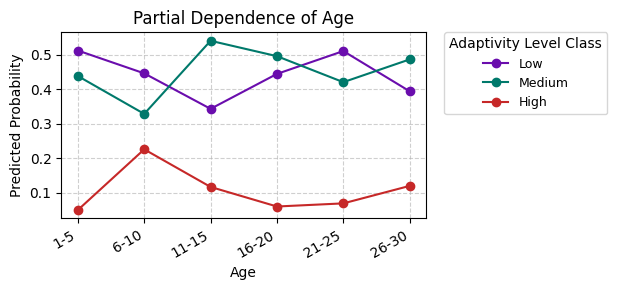

✅ Saved: boosting_visuals/pdp_plots\PDP_manual_Age.png


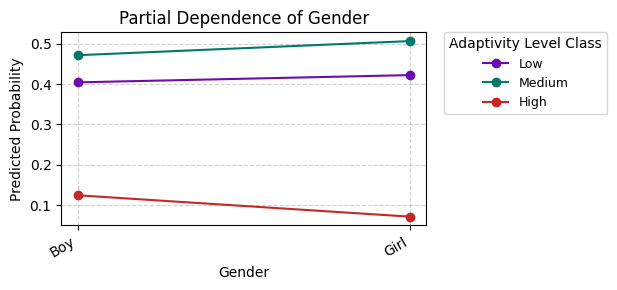

✅ Saved: boosting_visuals/pdp_plots\PDP_manual_Gender.png


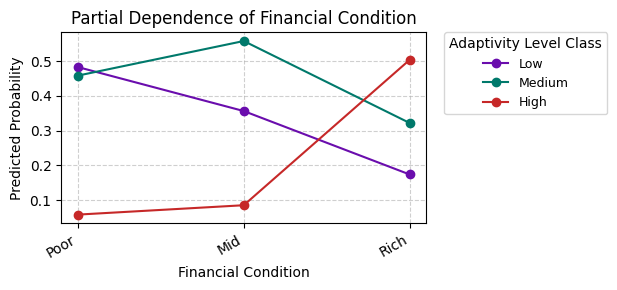

✅ Saved: boosting_visuals/pdp_plots\PDP_manual_Financial Condition.png


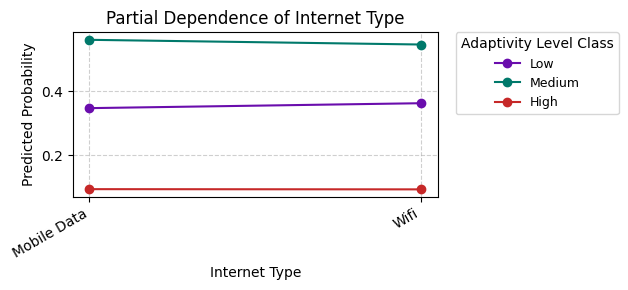

✅ Saved: boosting_visuals/pdp_plots\PDP_manual_Internet Type.png


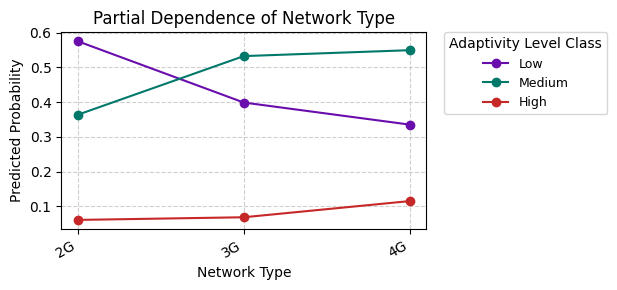

✅ Saved: boosting_visuals/pdp_plots\PDP_manual_Network Type.png


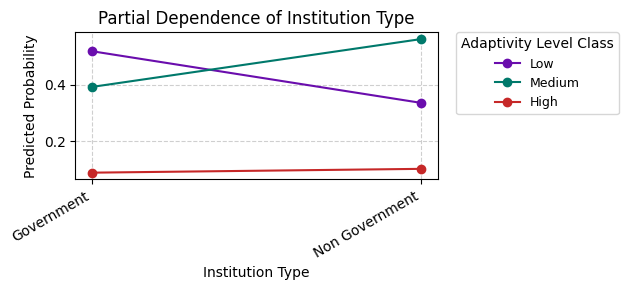

✅ Saved: boosting_visuals/pdp_plots\PDP_manual_Institution Type.png


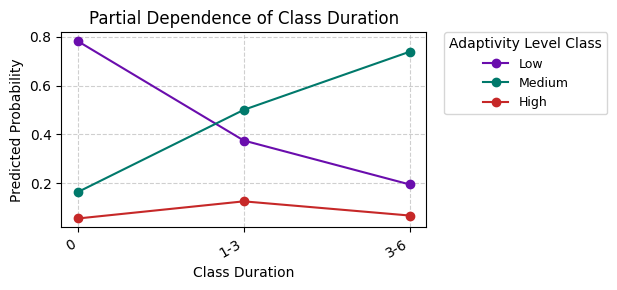

✅ Saved: boosting_visuals/pdp_plots\PDP_manual_Class Duration.png


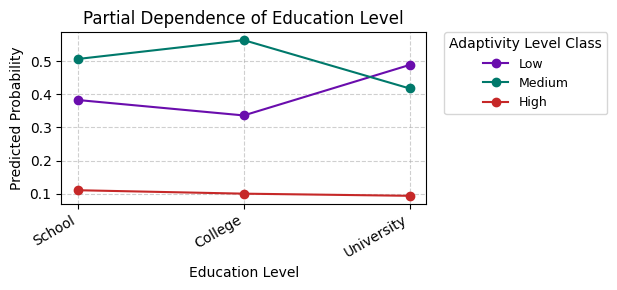

✅ Saved: boosting_visuals/pdp_plots\PDP_manual_Education Level.png


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os



# Categorical features to visualize
categorical_features = [
    'Age', 'Gender', 'Financial Condition', 'Internet Type', 'Network Type',
    'Institution Type', 'Class Duration', 'Education Level'
]

# Map target index to class name
target_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
class_colors = {'Low': '#6A0DAD',      
    'Medium': '#00796B',   
    'High': '#C62828'  }    
# ✅ Accurate label maps for categorical features
category_label_map = {
    'Gender': {0: 'Boy', 1: 'Girl'},
    'Institution Type': {0: 'Government', 1: 'Non Government'},
    
    'Internet Type': {0: 'Mobile Data', 1: 'Wifi'},
    
    'Age': {0: '1-5', 1: '6-10', 2: '11-15', 3: '16-20', 4: '21-25', 5: '26-30'},
    'Education Level': {0: 'School', 1: 'College', 2: 'University'},
    
    'Financial Condition': {0: 'Poor', 1: 'Mid', 2: 'Rich'},
    'Network Type': {0: '2G', 1: '3G', 2: '4G'},
    'Class Duration': {0: '0', 1: '1-3', 2: '3-6'},
    
}

# Loop through each categorical feature
for feature in categorical_features:
    categories = sorted(X_test[feature].unique(), key=str)

    # Convert encoded categories to human-readable labels
    display_categories = [
        category_label_map.get(feature, {}).get(cat, cat) for cat in categories
    ]

    plt.figure(figsize=(8, 3))

    # For each class (Low, Medium, High)
    for class_idx, class_name in target_mapping.items():
        pd_values = []

        # Replace feature with single category value and predict
        for cat in categories:
            X_temp = X_test.copy()
            X_temp[feature] = cat
            proba = best_lgb.predict_proba(X_temp)[:, class_idx]
            pd_values.append(np.mean(proba))

        plt.plot(range(len(categories)), pd_values, marker='o',color=class_colors[class_name], label=class_name)

    # X-axis labels and styling
    plt.xticks(range(len(categories)), display_categories, rotation=30, ha='right')
    plt.xlabel(feature, fontsize=10)
    plt.ylabel("Predicted Probability", fontsize=10)
    plt.title(f"Partial Dependence of {feature}", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Legend outside
    plt.legend(
        title='Adaptivity Level Class',
        fontsize=9,
        title_fontsize=10,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.
    )

    plt.tight_layout(rect=[0, 0, 0.8, 1])

    fname = os.path.join(pdp_dir, f"PDP_manual_{feature}.png")
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {fname}")
